In [8]:
import h5py
import matplotlib.pyplot as plt
import mpl_lego as mplego
import neuropacks
import numpy as np

from pyprojroot import here
from scipy.stats import wilcoxon
from mpl_lego.labels import add_significance_label

%matplotlib inline

In [9]:
mplego.style.use_latex_style()

In [10]:
ecog_data_path = '/storage/data/ecog/r32_b7.mat'
ecog_grid_path = '/storage/data/ecog/grdid.mat'
ecog = neuropacks.ECOG(data_path=ecog_data_path, grid_path=ecog_grid_path)

In [11]:
tc_results = h5py.File('/home/psachdeva/fits/neurobiases/ecog/fits2_remote.h5', 'r')
ecog_results = h5py.File(here('fits/ecog_results_em2.h5'), 'r')
b = np.array(ecog_results['b'][:])
n_electrodes = b.shape[0]
modulations_em = np.array([ecog.get_tuning_modulation_and_preference(tuning_coefs=b[idx], form='bf')[0] for idx in range(n_electrodes)]).ravel()

In [12]:
pvc_data_path = '/storage/data/pvc11/data/spikes_gratings/data_monkey1_gratings.mat'
pvc11 = neuropacks.PVC11(data_path=pvc_data_path)

In [13]:
em_pvc_results = h5py.File(here('fits/pvc11_results_em.h5'), 'r')
# tc_pvc_results = h5py.File('/storage/fits/neurobiases/pvc11/pvc11_monkey1.h5', 'r')
tc_pvc_results = h5py.File('/home/psachdeva/fits/neurobiases/pvc11/monkey1.h5', 'r')
b_em_pvc = np.array(em_pvc_results['b'][:])
modulations_em_pvc, preferences_em_pvc = pvc11.get_tuning_modulation_and_preference(form='cosine2', tuning_coefs=b_em_pvc)

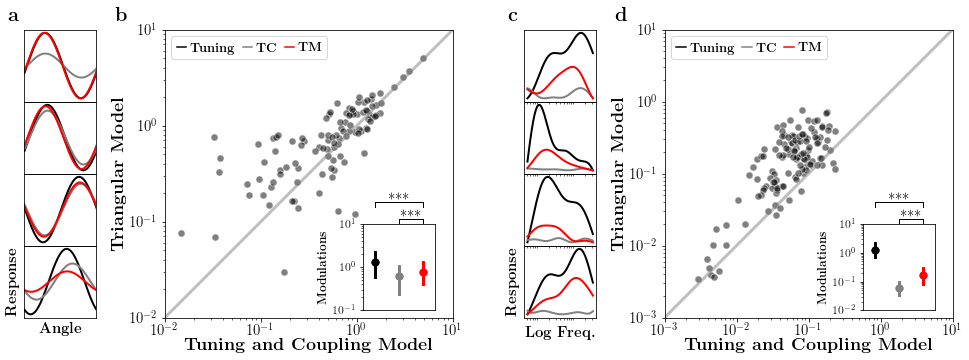

In [19]:
width = 5.5
height = 4
fig = plt.figure(figsize=(width, height))


#####################
### tuning curves ###
#####################
tc_x = 0
tc_y_base = 0
tc_w = 1
tc_h = 1

neuron_ids = np.array([49, 23, 103, 43])

# iterate over example neurons
for n_idx, neuron in enumerate(neuron_ids):
    # create axis
    tc = fig.add_axes([tc_x, tc_y_base +  n_idx * (tc_w / height), tc_w / width, tc_h / height])

    # plot tuning curves
    angles, t_tc = pvc11.get_tuning_curve(
        form='cosine2',
        tuning_coefs=np.mean(tc_pvc_results['t_cosine2/tuning_coefs'], axis=0)[neuron]
    )

    angles, tc_tc = pvc11.get_tuning_curve(
        form='cosine2',
        tuning_coefs=np.mean(tc_pvc_results['tc_cosine2_Lasso/tuning_coefs'], axis=0)[neuron]
    )

    angles, tc_em = pvc11.get_tuning_curve(
        form='cosine2',
        tuning_coefs=b_em_pvc[neuron]
    )
    
    tc.plot(angles, t_tc, color='black', linewidth=2)
    tc.plot(angles, tc_tc, color='gray', linewidth=2)
    tc.plot(angles, tc_em, color='red', linewidth=2)
    
    # bounds
    tc.set_xlim([0, 180])
    tc.set_xticks([])
    tc.set_yticks([])
    
    # labels
    if n_idx == 0:
        tc.set_xlabel(r'\textbf{Angle}', fontsize=15)
        tc.set_ylabel(r'\textbf{Response}', fontsize=15)

####################
### scatter plot ###
####################
scatter_x = tc_w + 0.95
scatter_y = 0
scatter_w = 4
scatter_h = 4

scatter = fig.add_axes([scatter_x / width, scatter_y, scatter_w / width, scatter_h / height])

# plot points from two monkeys
scatter.scatter(
    tc_pvc_results['tc_cosine2_Lasso/modulations_mean'][:],
    modulations_em_pvc,
    color='k',
    edgecolor='white',
    marker='o',
    alpha=0.5,
    s=50)

# plot placeholders for labels
scatter.plot([], color='k', label=r'\textbf{Tuning}')
scatter.plot([], color='gray', label=r'\textbf{TC}')
scatter.plot([], color='r', label=r'\textbf{TM}')

# create legend
lgd = scatter.legend(
    loc=2,
    handletextpad=0.3,
    handlelength=0.75,
    prop={'size': 13},
    ncol=3,
    columnspacing=0.6)

scatter.plot([0.01, 10], [0.01, 10], color='gray', linewidth=3, alpha=0.5)
scatter.set_xlim([0.01, 10])
scatter.set_ylim([0.01, 10])
scatter.set_xscale('log')
scatter.set_yscale('log')

scatter.set_xlabel(r'\textbf{Tuning and Coupling Model}', fontsize=18, labelpad=-1)
scatter.set_ylabel(r'\textbf{Triangular Model}', fontsize=18)
scatter.set_xticks([0.01, 0.1, 1, 10])
scatter.set_yticks([0.01, 0.1, 1, 10])

scatter.tick_params(labelsize=15)

modulations_x = tc_w + 3.7
modulations_y = 0.1
modulations_w = 1.
modulations_h = 1.2
modulations = fig.add_axes([modulations_x / width, modulations_y / height, modulations_w / width, modulations_h / height])

colors = ['k', 'gray', 'red']
markers = ['o', 'D', 'x']
offsets = [0.25, 0, -0.25]

for model_idx, model in enumerate([tc_pvc_results['t_cosine2/modulations_mean'][:],
                                   tc_pvc_results['tc_cosine2_Lasso/modulations_mean'][:],
                                   modulations_em_pvc]):
    modulations.boxplot(
        x=[model],
        positions=[model_idx],
        widths=0,
        boxprops={'linewidth': 3, 'color': colors[model_idx]},
        medianprops={'marker': 'o', 'markersize': 7, 'color': colors[model_idx]},
        whiskerprops={'linewidth': 0, 'color': colors[model_idx]},
        showfliers=False)

modulations.set_xlim([-0.5, 2.5])
modulations.set_ylim([0.1, 10])
modulations.set_yscale('log')
modulations.set_xticks([])
modulations.set_yticks([0.1, 1, 10])
modulations.tick_params(labelsize=12)
modulations.set_ylabel(r'\textbf{Modulations}', fontsize=12)

add_significance_label(modulations, bounds=[1, 2], label='***', fontsize=15)
add_significance_label(modulations, bounds=[0, 2], label='***', fontsize=15, spacing=0.2)



#####################
### tuning curves ###
#####################
tc_x2 = scatter_x / width + scatter_w / width + 0.18
tc_y_base2 = 0
tc_w2 = 1
tc_h2 = 1

electrode_ids = np.array([59, 77, 26, 62])

# iterate over example neurons
for e_idx, electrode in enumerate(electrode_ids):
    # create axis
    e_tc = fig.add_axes([tc_x2, tc_y_base2 +  e_idx * (tc_w2 / height), tc_w2 / width, tc_h2 / height])

    # plot tuning curves
    frequencies, t_tc = ecog.get_tuning_curve(
        tuning_coefs=np.mean(tc_results['t_bf_lasso/tuning_coefs'], axis=0)[electrode]
    )

    frequencies, tc_tc = ecog.get_tuning_curve(
        tuning_coefs=np.mean(tc_results['tc_bf_lasso/tuning_coefs'], axis=0)[electrode]
    )

    frequencies, tc_em = ecog.get_tuning_curve(
        tuning_coefs=b[electrode]
    )
    
    
    e_tc.plot(frequencies, t_tc.ravel() - t_tc.ravel().min(), color='black', linewidth=2)
    e_tc.plot(frequencies, tc_tc.ravel() - tc_tc.ravel().min(), color='gray', linewidth=2)
    e_tc.plot(frequencies, tc_em.ravel() - tc_em.ravel().min(), color='red', linewidth=2)
    
    # bounds
    #tc.set_xlim([0, 180])
    e_tc.set_xscale('log')
    e_tc.set_xticks([])
    e_tc.set_yticks([])
    
    # labels
    if e_idx == 0:
        e_tc.set_xlabel(r'\textbf{Log Freq.}', fontsize=15)
        e_tc.set_ylabel(r'\textbf{Response}', fontsize=15)

####################
### scatter plot ###
####################
scatter_x = tc_x2 + tc_w2 / width + 0.95 / width
scatter_y = 0
scatter_w = 4
scatter_h = 4

scatter2 = fig.add_axes([scatter_x, scatter_y, scatter_w / width, scatter_h / height])

# plot points from two monkeys
scatter2.scatter(
    np.mean(tc_results['tc_bf_lasso/modulations'][:], axis=0),
    modulations_em,
    color='k',
    edgecolor='white',
    marker='o',
    alpha=0.5,
    s=50)

# plot placeholders for labels
scatter2.plot([], color='k', label=r'\textbf{Tuning}')
scatter2.plot([], color='gray', label=r'\textbf{TC}')
scatter2.plot([], color='r', label=r'\textbf{TM}')

# create legend
lgd = scatter2.legend(
    loc=3,
    handletextpad=0.1,
    handlelength=1,
    prop={'size': 13},
    ncol=2,
    columnspacing=0.4)

scatter2.plot([0.001, 10], [0.001, 10], color='gray', linewidth=3, alpha=0.5)
scatter2.set_xlim([0.001, 10])
scatter2.set_ylim([0.001, 10])
scatter2.set_xscale('log')
scatter2.set_yscale('log')

scatter2.set_xlabel(r'\textbf{Tuning and Coupling Model}', fontsize=18, labelpad=-1)
scatter2.set_ylabel(r'\textbf{Triangular Model}', fontsize=18)
scatter2.set_xticks([0.001, 0.01, 0.1, 1, 10])
scatter2.set_yticks([0.001, 0.01, 0.1, 1, 10])


scatter2.tick_params(labelsize=15)

modulations_x = tc_x2 * width + 3.7 + tc_w2
modulations_y = 0.1
modulations_w = 1.
modulations_h = 1.2
modulations = fig.add_axes([modulations_x / width, modulations_y / height, modulations_w / width, modulations_h / height])

colors = ['k', 'gray', 'red']
offsets = [0.25, 0, -0.25]

for model_idx, model in enumerate([np.mean(tc_results['t_bf_lasso/modulations'][:], axis=0),
                                   np.mean(tc_results['tc_bf_lasso/modulations'][:], axis=0),
                                   modulations_em]):
    modulations.boxplot(
        x=[model],
        positions=[model_idx],
        widths=0,
        boxprops={'linewidth': 3, 'color': colors[model_idx]},
        medianprops={'marker': 'o', 'markersize': 7, 'color': colors[model_idx]},
        whiskerprops={'linewidth': 0, 'color': colors[model_idx]},
        showfliers=False)


modulations.set_xlim([-0.5, 2.5])
modulations.set_ylim([0.01, 10])
modulations.set_yscale('log')
modulations.set_xticks([])
modulations.set_yticks([0.01, 0.1, 1, 10])
modulations.tick_params(labelsize=12)
modulations.set_ylabel(r'\textbf{Modulations}', fontsize=12)

add_significance_label(modulations, bounds=[1, 2], label='***', fontsize=15)
add_significance_label(modulations, bounds=[0, 2], label='***', fontsize=15, spacing=0.2)

# create legend
lgd = scatter2.legend(
    loc=2,
    handletextpad=0.3,
    handlelength=0.75,
    prop={'size': 13},
    ncol=3,
    columnspacing=0.6)

mplego.labels.apply_subplot_labels([tc, e_tc], y=1.2, labels=['a', 'c'], bold=True, size=20)
mplego.labels.apply_subplot_labels([scatter, scatter2], labels=['b', 'd'], bold=True, size=20)
plt.savefig('figure4.pdf', bbox_inches='tight')